In [1]:
import numpy as np
import argparse
import imageio
import os
import sys
import time
import torch
from datasets import load_dataset
from vae import HallucVAE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from torchvision.transforms import ToTensor
from data import set_up_data, set_up_imagenet64
from utils import get_cpu_stats_over_ranks
from train_helpers import set_up_hyperparams, load_vaes, load_opt, accumulate_stats, save_model, update_ema, Hyperparams, add_vae_arguments, parse_args_and_update_hparams, setup_mpi, setup_save_dirs, logger

/home/mila/c/colin.bredenberg/scratch/vdvae/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def training_step(H, data_input, target, vae, ema_vae, optimizer, iterate):
    t0 = time.time()
    vae.zero_grad()
    stats = vae.forward(data_input, target)
    stats['elbo'].backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(vae.parameters(), H.grad_clip).item()
    distortion_nans = torch.isnan(stats['distortion']).sum()
    rate_nans = torch.isnan(stats['rate']).sum()
    stats.update(dict(rate_nans=0 if rate_nans == 0 else 1, distortion_nans=0 if distortion_nans == 0 else 1))
    stats = get_cpu_stats_over_ranks(stats)

    skipped_updates = 1
    # only update if no rank has a nan and if the grad norm is below a specific threshold
    if stats['distortion_nans'] == 0 and stats['rate_nans'] == 0 and (H.skip_threshold == -1 or grad_norm < H.skip_threshold):
        optimizer.step()
        skipped_updates = 0
        update_ema(vae, ema_vae, H.ema_rate)

    t1 = time.time()
    stats.update(skipped_updates=skipped_updates, iter_time=t1 - t0, grad_norm=grad_norm)
    return stats


def eval_step(data_input, target, ema_vae):
    with torch.no_grad():
        stats = ema_vae.forward(data_input, target)
    stats = get_cpu_stats_over_ranks(stats)
    return stats


def get_sample_for_visualization(data, preprocess_fn, num, dataset):
    for x in DataLoader(data, batch_size=num):
        break
    orig_image = (x[0] * 255.0).to(torch.uint8).permute(0, 2, 3, 1) if dataset == 'ffhq_1024' else x[0]
    preprocessed = preprocess_fn(x)[0]
    return orig_image, preprocessed


def train_loop(H, data_train, data_valid, preprocess_fn, vae, ema_vae, logprint):
    optimizer, scheduler, cur_eval_loss, iterate, starting_epoch = load_opt(H, vae, logprint)
    # train_sampler = DistributedSampler(data_train, num_replicas=H.mpi_size, rank=H.rank)
    train_sampler = SequentialSampler(data_train)
    viz_batch_original, viz_batch_processed = get_sample_for_visualization(data_valid, preprocess_fn, H.num_images_visualize, H.dataset)
    early_evals = set([1] + [2 ** exp for exp in range(3, 14)])
    stats = []
    iters_since_starting = 0
    H.ema_rate = torch.as_tensor(H.ema_rate).cuda()
    for epoch in range(starting_epoch, H.num_epochs):
        train_sampler.set_epoch(epoch)
        for x in DataLoader(data_train, batch_size=H.n_batch, drop_last=True, pin_memory=True, sampler=train_sampler):
            data_input, target = preprocess_fn(x)
            training_stats = training_step(H, data_input, target, vae, ema_vae, optimizer, iterate)
            stats.append(training_stats)
            scheduler.step()
            if iterate % H.iters_per_print == 0 or iters_since_starting in early_evals:
                logprint(model=H.desc, type='train_loss', lr=scheduler.get_last_lr()[0], epoch=epoch, step=iterate, **accumulate_stats(stats, H.iters_per_print))

            if iterate % H.iters_per_images == 0 or (iters_since_starting in early_evals and H.dataset != 'ffhq_1024') and H.rank == 0:
                write_images(H, ema_vae, viz_batch_original, viz_batch_processed, f'{H.save_dir}/samples-{iterate}.png', logprint)

            iterate += 1
            iters_since_starting += 1
            if iterate % H.iters_per_save == 0 and H.rank == 0:
                if np.isfinite(stats[-1]['elbo']):
                    logprint(model=H.desc, type='train_loss', epoch=epoch, step=iterate, **accumulate_stats(stats, H.iters_per_print))
                    fp = os.path.join(H.save_dir, 'latest')
                    logprint(f'Saving model@ {iterate} to {fp}')
                    save_model(fp, vae, ema_vae, optimizer, H)

            if iterate % H.iters_per_ckpt == 0 and H.rank == 0:
                save_model(os.path.join(H.save_dir, f'iter-{iterate}'), vae, ema_vae, optimizer, H)

        if epoch % H.epochs_per_eval == 0:
            valid_stats = evaluate(H, ema_vae, data_valid, preprocess_fn)
            logprint(model=H.desc, type='eval_loss', epoch=epoch, step=iterate, **valid_stats)


def evaluate(H, ema_vae, data_valid, preprocess_fn):
    stats_valid = []
    # valid_sampler = DistributedSampler(data_valid, num_replicas=H.mpi_size, rank=H.rank)
    valid_sampler = SequentialSampler(data_valid)
    for x in DataLoader(data_valid, batch_size=H.n_batch, drop_last=True, pin_memory=True, sampler=valid_sampler):
        data_input, target = preprocess_fn(x)
        stats_valid.append(eval_step(data_input, target, ema_vae))
    vals = [a['elbo'] for a in stats_valid]
    finites = np.array(vals)[np.isfinite(vals)]
    stats = dict(n_batches=len(vals), filtered_elbo=np.mean(finites), **{k: np.mean([a[k] for a in stats_valid]) for k in stats_valid[-1]})
    return stats


def write_images(H, ema_vae, viz_batch_original, viz_batch_processed, fname, logprint):
    zs = [s['z'].cuda() for s in ema_vae.forward_get_latents(viz_batch_processed)]
    batches = [viz_batch_original.numpy()]
    mb = viz_batch_processed.shape[0]
    lv_points = np.floor(np.linspace(0, 1, H.num_variables_visualize + 2) * len(zs)).astype(int)[1:-1]
    for i in lv_points:
        batches.append(ema_vae.forward_samples_set_latents(mb, zs[:i], t=0.1))
    for t in [1.0, 0.9, 0.8, 0.7][:H.num_temperatures_visualize]:
        batches.append(ema_vae.forward_uncond_samples(mb, t=t))
    n_rows = len(batches)
    im = np.concatenate(batches, axis=0).reshape((n_rows, mb, *viz_batch_processed.shape[1:])).transpose([0, 2, 1, 3, 4]).reshape([n_rows * viz_batch_processed.shape[1], mb * viz_batch_processed.shape[2], 3])
    logprint(f'printing samples to {fname}')
    imageio.imwrite(fname, im)


def run_test_eval(H, ema_vae, data_test, preprocess_fn, logprint):
    print('evaluating')
    stats = evaluate(H, ema_vae, data_test, preprocess_fn)
    print('test results')
    for k in stats:
        print(k, stats[k])
    logprint(type='test_loss', **stats)


def main():
    H, logprint = set_up_hyperparams()
    H, data_train, data_valid_or_test, preprocess_fn = set_up_data(H)
    vae, ema_vae = load_vaes(H, logprint)
    if H.test_eval:
        run_test_eval(H, ema_vae, data_valid_or_test, preprocess_fn, logprint)
    else:
        train_loop(H, data_train, data_valid_or_test, preprocess_fn, vae, ema_vae, logprint)

In [ ]:
def set_up_notebook_hps(s = None):
    H = Hyperparams()
    parser = argparse.ArgumentParser()
    parser = add_vae_arguments(parser)
    parse_args_and_update_hparams(H, parser, s=s)
    setup_mpi(H)
    setup_save_dirs(H)
    logprint = logger(H.logdir)
    for i, k in enumerate(sorted(H)):
        logprint(type='hparam', key=k, value=H[k])
    np.random.seed(H.seed)
    torch.manual_seed(H.seed)
    # torch.cuda.manual_seed(H.seed)
    logprint('training model', H.desc, 'on', H.dataset)
    return H, logprint

dataset = "imagenet64"

if dataset == "ffhq256":
    original_argv = sys.argv
    sys.argv = ['halluc.ipynb', '--hps', 'ffhq256', '--restore_path', 'ffhq256-iter-1700000-model.th', '--restore_ema_path', 'ffhq256-iter-1700000-model-ema.th', '--restore_log_path', 'ffhq256-iter-1700000-log.jsonl', '--restore_optimizer_path', 'ffhq256-iter-1700000-opt.th', '--test_eval']

    H, logprint = set_up_notebook_hps()
    H, data_train, data_valid_or_test, preprocess_fn = set_up_data(H)
    del data_train

elif dataset == "imagenet64":
    original_argv = sys.argv
    sys.argv = ['halluc.ipynb', '--hps', 'imagenet64', '--restore_path', 'imagenet64-iter-1600000-model.th', '--restore_ema_path', 'imagenet64-iter-1600000-model-ema.th', '--restore_log_path', 'imagenet64-iter-1600000-log.jsonl', '--restore_optimizer_path', 'imagenet64-iter-1600000-opt.th', '--test_eval']

    ds = load_dataset("zh-plus/tiny-imagenet")
    offset = 3
    a = ds['valid']['image'][offset:(1000 + offset):100]
    fig, ax = plt.subplots(1,10, figsize = (10*3, 3))
    for ii in range(0,10):
        ax[ii].imshow(a[ii])
        ax[ii].set_xticks([])
        ax[ii].set_yticks([])
    to_tensor_transform = ToTensor()
    valid_list = []
    for im in ds['valid']['image']:
        im_tensor = to_tensor_transform(im)
        if im_tensor.shape[0] == 3:
            valid_list.append(im_tensor)
    validation_set = torch.stack(valid_list).permute([0,2,3,1])

    H, logprint = set_up_notebook_hps()
    H, data_valid_or_test, preprocess_fn = set_up_imagenet64(H, validation_set)


time: Tue Sep 30 11:10:36 2025, type: hparam, key: adam_beta1, value: 0.90000
time: Tue Sep 30 11:10:36 2025, type: hparam, key: adam_beta2, value: 0.90000
time: Tue Sep 30 11:10:36 2025, type: hparam, key: bottleneck_multiple, value: 0.25000
time: Tue Sep 30 11:10:36 2025, type: hparam, key: custom_width_str, value: 
time: Tue Sep 30 11:10:36 2025, type: hparam, key: data_root, value: ./
time: Tue Sep 30 11:10:36 2025, type: hparam, key: dataset, value: ffhq_256
time: Tue Sep 30 11:10:36 2025, type: hparam, key: dec_blocks, value: 1x2,4m1,4x3,8m4,8x4,16m8,16x9,32m16,32x21,64m32,64x13,128m64,128x7,256m128
time: Tue Sep 30 11:10:36 2025, type: hparam, key: desc, value: test
time: Tue Sep 30 11:10:36 2025, type: hparam, key: ema_rate, value: 0.99900
time: Tue Sep 30 11:10:36 2025, type: hparam, key: enc_blocks, value: 256x3,256d2,128x8,128d2,64x12,64d2,32x17,32d2,16x7,16d2,8x5,8d2,4x5,4d4,1x4
time: Tue Sep 30 11:10:36 2025, type: hparam, key: epochs_per_eval, value: 1
time: Tue Sep 30 11

In [4]:
valid_sampler = RandomSampler(data_valid_or_test)
data_loader =  DataLoader(data_valid_or_test, batch_size=1, drop_last=True, pin_memory=True, sampler=valid_sampler)
batch_size = 10
data_inputs = []
data_zeros = []
targets = []
data_loader_iter = iter(data_loader)
for ii in range(0, batch_size):
    data = next(data_loader_iter)
    data_input, target = preprocess_fn(data)
    data_zero, _ = preprocess_fn([torch.zeros(data[0].shape)])
    data_inputs.append(data_input)
    data_zeros.append(data_zero)
    targets.append(target)

print(data_input.shape)
torch.save([data_inputs, data_zeros, targets, H] , "example_input.pt")

torch.Size([1, 256, 256, 3])


time: Tue Sep 30 11:08:03 2025, message: Restoring vae from ffhq256-iter-1700000-model.th
time: Tue Sep 30 11:08:05 2025, message: Restoring ema vae from ffhq256-iter-1700000-model-ema.th
time: Tue Sep 30 11:08:08 2025, total_params: 114874852, readable: 114,874,852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5299934..1.9776332].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6158944..-1.6158944].


torch.Size([10, 256, 256, 3])


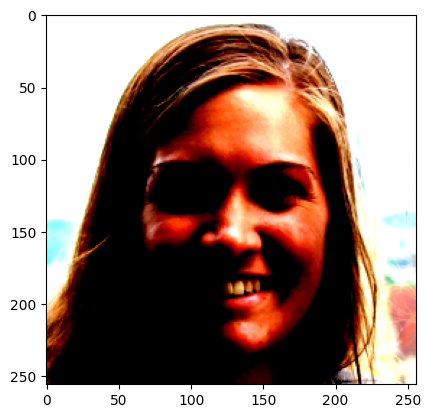

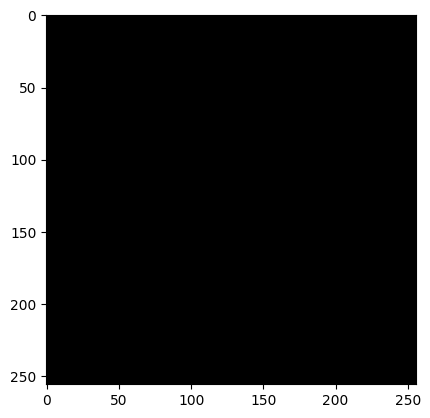

In [5]:
# H, logprint = set_up_notebook_hps()
example_inputs, zero_inputs, targets, H= torch.load("example_input.pt", weights_only=False)
vae, ema_vae = load_vaes(H, logprint)
input_data = torch.vstack(example_inputs)
zero_data = torch.vstack(zero_inputs)
print(input_data.shape)
plt.imshow(input_data[1,...].cpu())

plt.figure()
plt.imshow(zero_data[1,...].cpu())

In [6]:
halluc_vae = HallucVAE(ema_vae)

#input-conditioned hallucinations
step_num = 6
abstraction_depth = 35 #use encoder for top K layers
alpha_range = np.array([0., 0.6, 0.7, 0.8, 0.9, 1.0])#np.arange(0, 1.2, 0.2)
samples = []
for idx, a in enumerate(alpha_range):
    sample, metrics = halluc_vae.mixed_sample(input_data, alpha = a, depth = abstraction_depth)
    samples.append(sample)

#closed eyes hallucinations
zero_samples = []
for idx, a in enumerate(alpha_range):
    sample, metrics = halluc_vae.mixed_sample(zero_data, alpha = a, depth = abstraction_depth)
    zero_samples.append(sample)

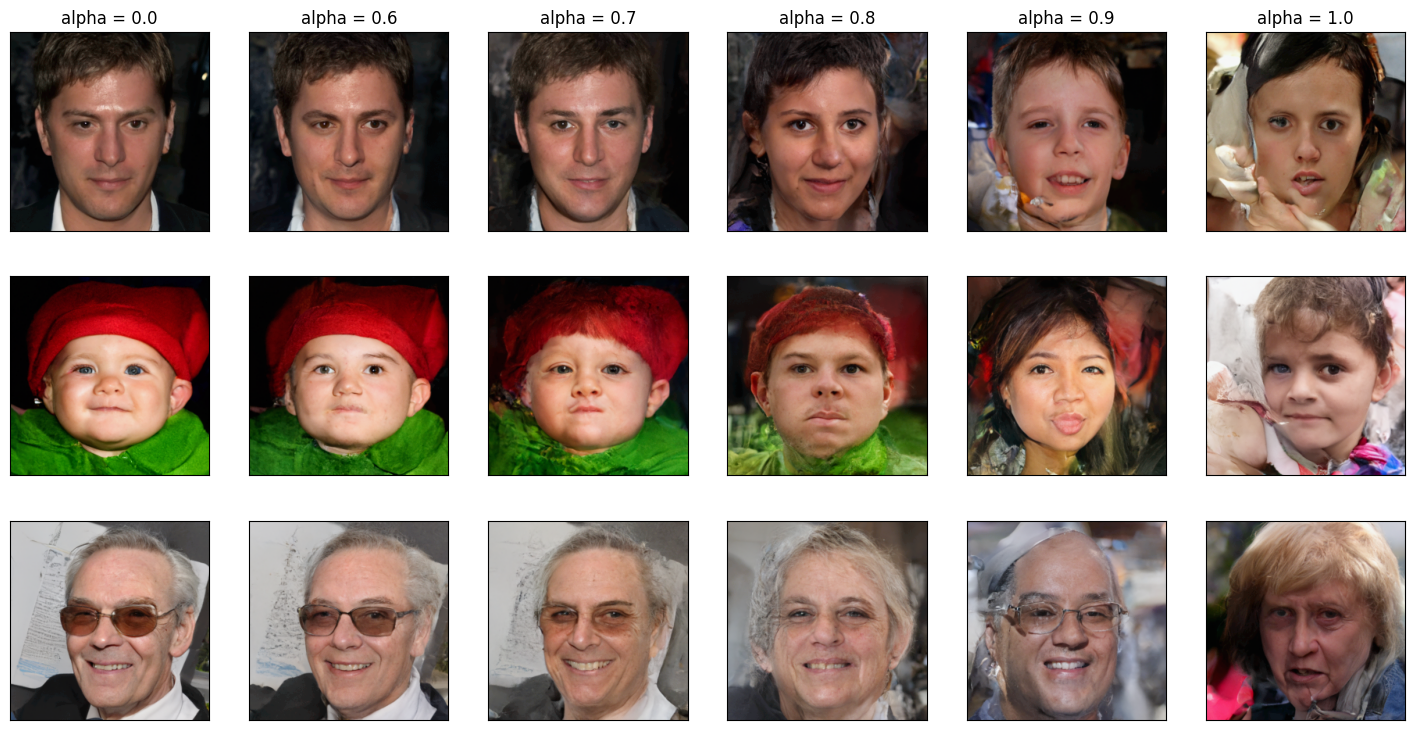

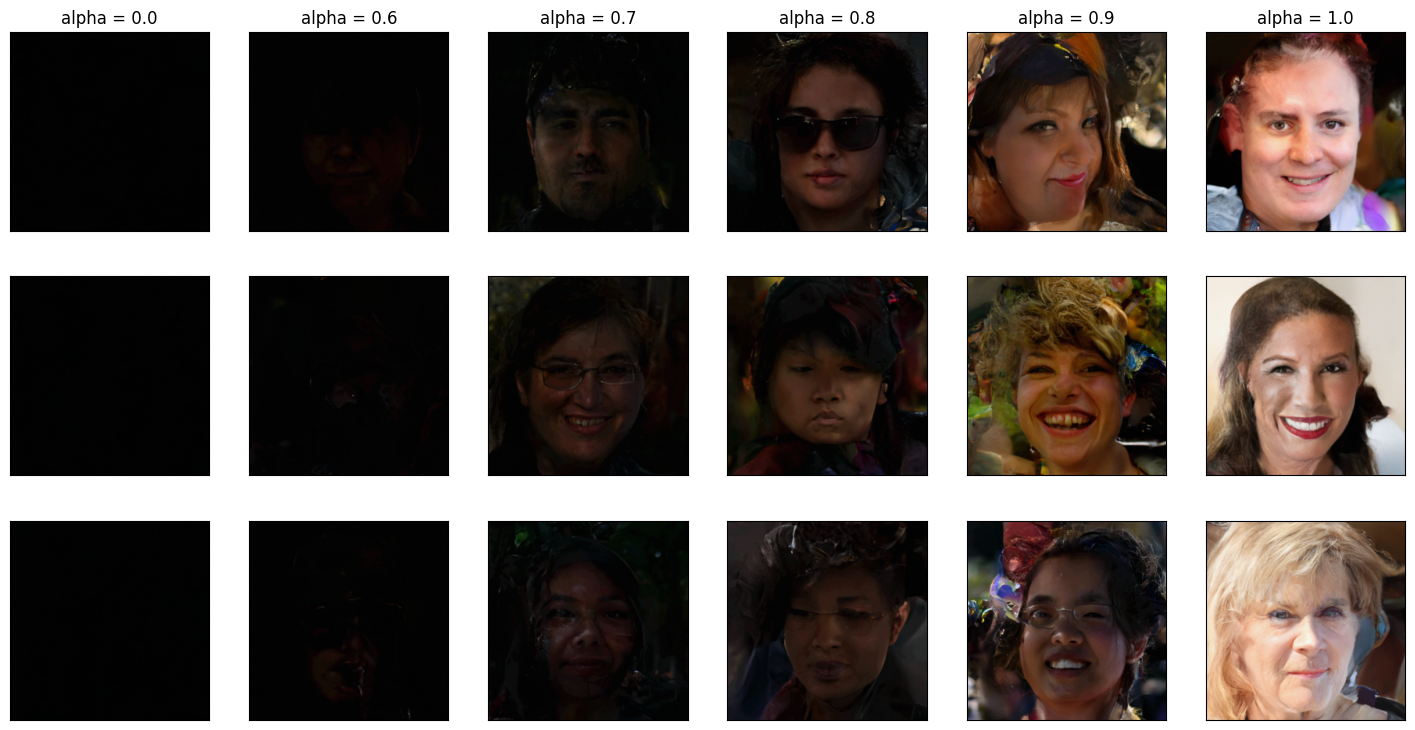

In [7]:
savepath = "./"
sample_num = 3
fig, ax = plt.subplots(sample_num, step_num, figsize = (3 * step_num, 3 * sample_num))
sample_idxs = [2, 5, 8]
for ii in range(0, len(alpha_range)):
    for jj in range(0, sample_num):
        ax[jj,ii].imshow(samples[ii][sample_idxs[jj],...])
        ax[jj,ii].set_xticks([])
        ax[jj,ii].set_yticks([])
    ax[0,ii].set_title(f"alpha = {round(alpha_range[ii],2)}", fontsize = 12)
fig.savefig(savepath + f"{dataset}_halluc.pdf", format = 'pdf')
sample_num = 3
fig, ax = plt.subplots(sample_num, step_num, figsize = (3 * step_num, 3 * sample_num))
for ii in range(0, len(alpha_range)):
    for jj in range(0, sample_num):
        ax[jj,ii].imshow(zero_samples[ii][sample_idxs[jj],...])
        ax[jj,ii].set_xticks([])
        ax[jj,ii].set_yticks([])
    ax[0,ii].set_title(f"alpha = {round(alpha_range[ii],2)}", fontsize = 12)
fig.savefig(savepath + f"{dataset}_halluc_closed_eyes.pdf", format = 'pdf')


In [8]:
# stimulus conditioned representation variance
from tqdm import tqdm
valid_sampler = RandomSampler(data_valid_or_test)
batch_size = 1
data_loader =  DataLoader(data_valid_or_test, batch_size=1, drop_last=True, pin_memory=True, sampler=valid_sampler)

halluc_vae = HallucVAE(ema_vae)

sample_num = 100
repetition_num = 32
abstraction_depth = 35 #use encoder for top K layers
alpha_range = np.arange(0, 1.1, 0.1)
metrics = {a: [] for a in alpha_range}

data_iterable = iter(data_loader)
for ii in tqdm(range(0, sample_num)):
    for idx, a in enumerate(alpha_range):
        input_data = next(data_iterable)
        data, _ = preprocess_fn(input_data)
        data = data.repeat(repetition_num, 1, 1, 1)
        sample, metric = halluc_vae.mixed_sample(data, alpha = a, depth = abstraction_depth, metrics = ['variance'])
        metrics[a].append(metric)


  0%|          | 0/100 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU 0 has a total capacity of 31.73 GiB of which 6.37 GiB is free. Including non-PyTorch memory, this process has 25.36 GiB memory in use. Of the allocated memory 21.05 GiB is allocated by PyTorch, and 3.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

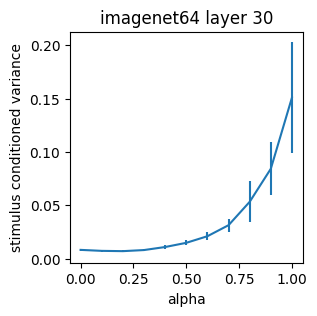

In [79]:
savepath = "./"
res = 16 #corresponds to layer 30
corresponding_layer = 30
layer_vars = {a: [metrics[a][ii]['variance'][res] for ii in range(0, len(metrics[a]))] for a in metrics.keys()}
layer_vars_mean = {a: torch.mean(torch.stack(layer_vars[a])) for a in layer_vars.keys()}
layer_vars_sem = {a: torch.std(torch.stack(layer_vars[a]))/np.sqrt(len(torch.stack(layer_vars[a]))) for a in layer_vars.keys()}
layer_vars_mean = torch.tensor(list(layer_vars_mean.values()))
layer_vars_sem = torch.tensor(list(layer_vars_sem.values()))

fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.errorbar(alpha_range, layer_vars_mean, yerr = layer_vars_sem)
plt.title(f'{dataset} layer {corresponding_layer}')
plt.xlabel('alpha')
plt.ylabel('stimulus conditioned variance')
fig.savefig(savepath + f"{dataset}_stim_cond_var.pdf", format = 'pdf')

In [ ]:
# effects of top-down inactivation
from tqdm import tqdm
valid_sampler = RandomSampler(data_valid_or_test)
batch_size = 100
data_loader =  DataLoader(data_valid_or_test, batch_size=batch_size, drop_last=True, pin_memory=True, sampler=valid_sampler)

halluc_vae = HallucVAE(ema_vae)

abstraction_depth = 35 #use encoder for top K layers
alpha_range = np.arange(0, 1.1, 0.1)
metrics = {a: [] for a in alpha_range}
metrics_inact = {a: [] for a in alpha_range}
samples = {a: [] for a in alpha_range}

sample_num = 1
data_iterable = iter(data_loader)
layer_inactivation_list = list(range(0,20)) #inactivate top 20 layers
for ii in tqdm(range(0, sample_num)):
    input_data = next(data_iterable)
    for idx, a in enumerate(alpha_range):
        data, _ = preprocess_fn(input_data)
        sample, metric = halluc_vae.mixed_sample(data, alpha = a, depth = abstraction_depth, metrics = ['variance', 'spatial_covariance'])
        metrics[a].append(metric)
        samples[a].append(sample)

        sample_inact, metric_inact = halluc_vae.mixed_sample(data, alpha = a, depth = abstraction_depth, metrics = ['variance'], inact_inputs = layer_inactivation_list)
        metrics_inact[a].append(metric_inact)

  0%|          | 0/1 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.50 GiB. GPU 0 has a total capacity of 31.73 GiB of which 1.26 GiB is free. Including non-PyTorch memory, this process has 30.47 GiB memory in use. Of the allocated memory 23.82 GiB is allocated by PyTorch, and 5.84 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

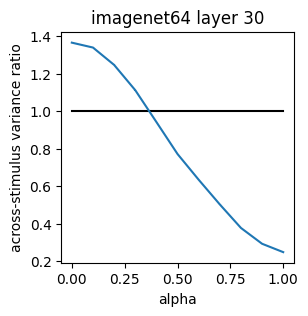

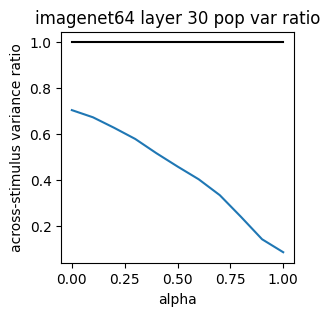

In [18]:
savepath = "./"
res = 16
corresponding_layer = 30
layer_vars = {a: [metrics[a][ii]['variance'][res] for ii in range(0, len(metrics[a]))] for a in metrics.keys()}
layer_vars_inact = {a: [metrics_inact[a][ii]['variance'][res] for ii in range(0, len(metrics_inact[a]))] for a in metrics_inact.keys()}

eps = 1e-3
var_ratio_mean = {a: torch.mean((torch.stack(layer_vars_inact[a]) + eps) / (torch.stack(layer_vars[a]) + eps)) for a in layer_vars.keys()}
var_ratio_std = {a: torch.std((torch.stack(layer_vars_inact[a]) + eps)/ (torch.stack(layer_vars[a]) + eps)) for a in layer_vars.keys()}
var_ratio_mean = torch.tensor(list(var_ratio_mean.values()))
var_ratio_std = torch.tensor(list(var_ratio_std.values()))
var_ratio_sem = var_ratio_std / np.sqrt(np.prod(torch.stack(layer_vars_inact[0.]).shape))
# layer_vars_mean_inact = {a: torch.mean(torch.stack(layer_vars_inact[a])) for a in layer_vars_inact.keys()}
# layer_vars_sem_inact = {a: torch.std(torch.stack(layer_vars_inact[a]))/np.sqrt(len(torch.stack(layer_vars_inact[a]))) for a in layer_vars_inact.keys()}
# layer_vars_mean_inact = torch.tensor(list(layer_vars_mean_inact.values()))

fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.errorbar(alpha_range, var_ratio_mean, yerr = var_ratio_sem)
plt.plot(alpha_range, torch.ones_like(var_ratio_mean), 'k')
# plt.plot(alpha_range, layer_vars_mean_inact)
plt.title(f'{dataset} layer {corresponding_layer}')
plt.xlabel('alpha')
plt.ylabel('across-stimulus variance ratio')
fig.savefig(savepath + f"{dataset}_var_ratio_inact.pdf", format = 'pdf')


var_ratio_pop = {a: (torch.mean(torch.stack(layer_vars_inact[a])) + eps) / (torch.mean(torch.stack(layer_vars[a])) + eps) for a in layer_vars.keys()}
var_ratio_pop = torch.tensor(list(var_ratio_pop.values()))
fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.plot(alpha_range, var_ratio_pop)
plt.plot(alpha_range, torch.ones_like(var_ratio_pop), 'k')
# plt.plot(alpha_range, layer_vars_mean_inact)
plt.title(f'{dataset} layer {corresponding_layer} pop var ratio')
plt.xlabel('alpha')
plt.ylabel('across-stimulus variance ratio')
fig.savefig(savepath + f"{dataset}_var_ratio_inact_population.pdf", format = 'pdf')

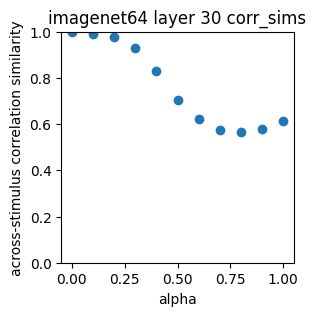

In [19]:
#correlation similarity plots
def corr_similarity(mat_1, mat_2):
    return torch.corrcoef(torch.stack([mat_1.flatten(), mat_2.flatten()]))[0,1]

def cosine_similarity(mat_1, mat_2):
    flat_1 =  mat_1.flatten() / torch.linalg.norm(mat_1.flatten(), keepdims = True)
    flat_2 = mat_2.flatten() / torch.linalg.norm(mat_2.flatten(), keepdims = True)
    return torch.matmul(flat_1, flat_2)

savepath = "./"
res = 16
corresponding_layer = 30
layer_covs = {a: [metrics[a][ii]['spatial_covariance'][res] for ii in range(0, len(metrics[a]))] for a in metrics.keys()}
layer_stds = {a: torch.sqrt(torch.diag(torch.diag(layer_covs[a][0]))) for a in layer_covs.keys()}
layer_corrs = {a: torch.linalg.inv(layer_stds[a]) @ layer_covs[a][0] @ torch.linalg.inv(layer_stds[a]) for a in layer_covs.keys()}

# correlation_similarities = {a: corr_similarity(layer_corrs[0.].cpu() - torch.eye(layer_corrs[0.].shape[0]), layer_corrs[a].cpu() - torch.eye(layer_corrs[0.].shape[0])) for a in layer_corrs.keys()}
correlation_similarities = {a: cosine_similarity(torch.triu(layer_corrs[0.].cpu(), diagonal = 1), torch.triu(layer_corrs[a].cpu(), diagonal = 1)) for a in layer_corrs.keys()}

corr_sims = torch.tensor(list(correlation_similarities.values()))
fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.scatter(alpha_range, corr_sims)
plt.title(f'{dataset} layer {corresponding_layer} corr_sims')
plt.xlabel('alpha')
plt.ylabel('across-stimulus correlation similarity')
plt.ylim([0,1])
fig.savefig(savepath + f"{dataset}_correlation_similarities.pdf", format = 'pdf')



Text(0, 0.5, 'base image correlation similarity')

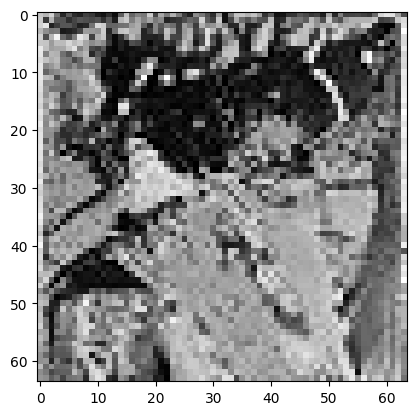

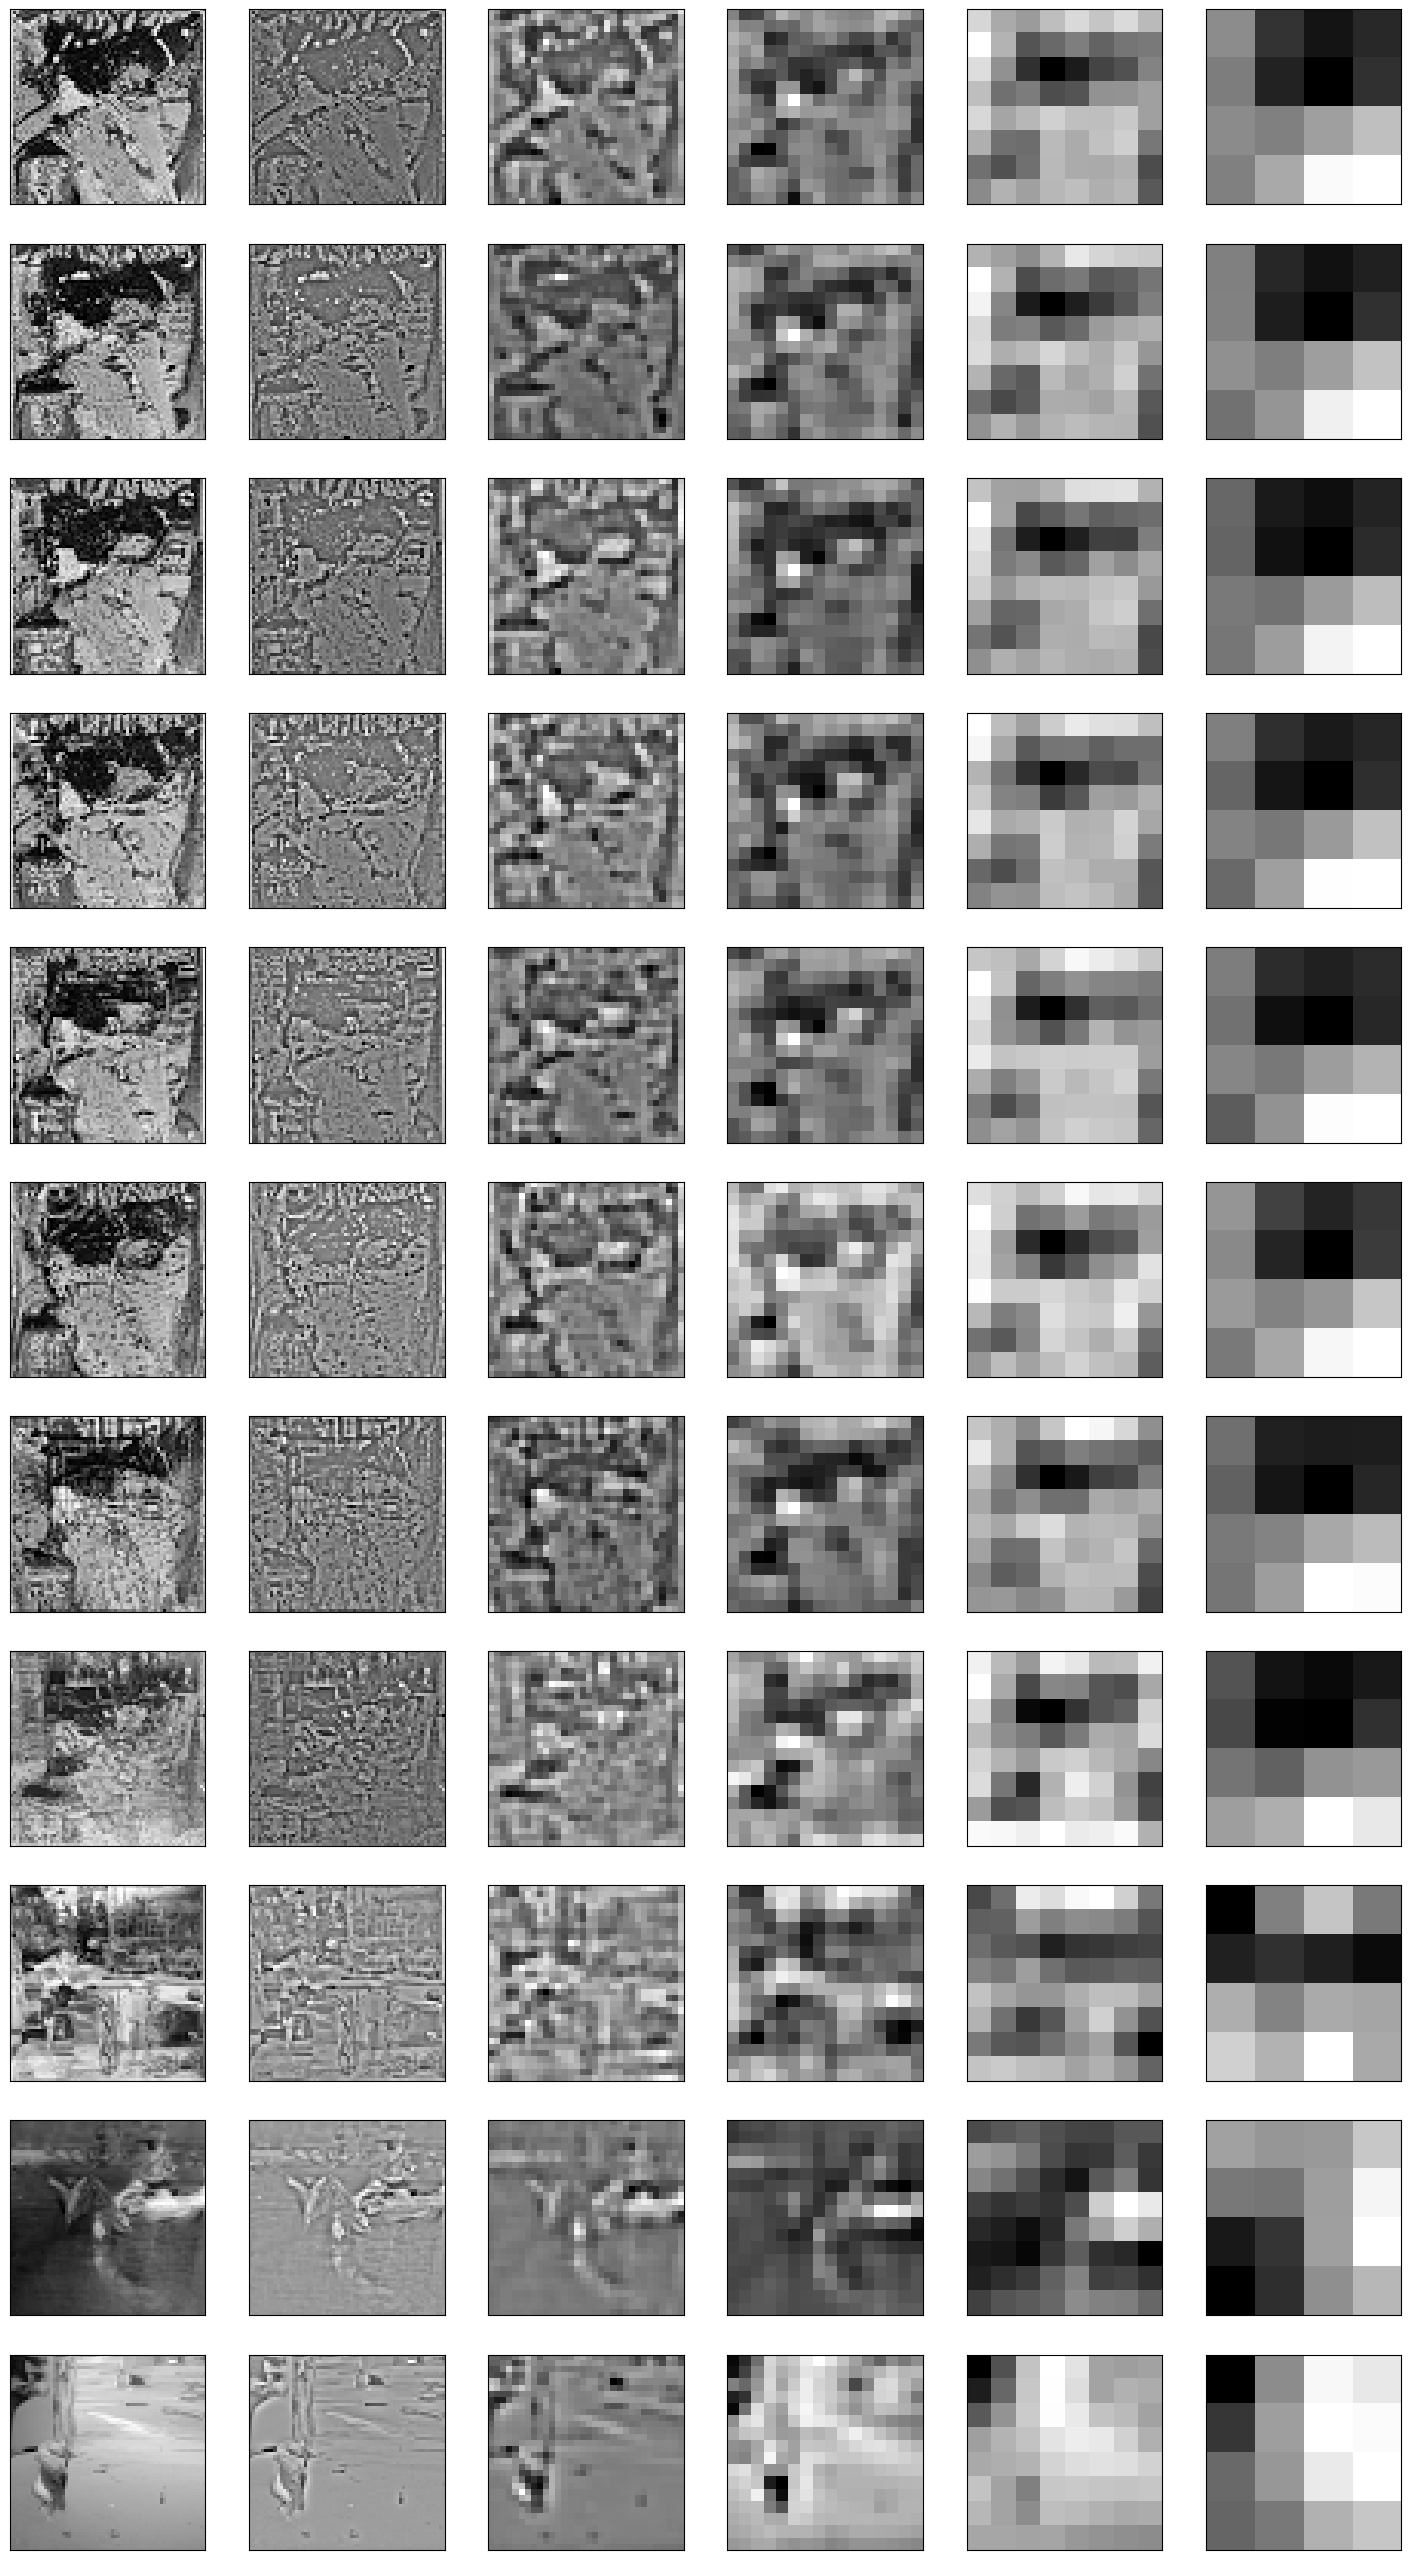

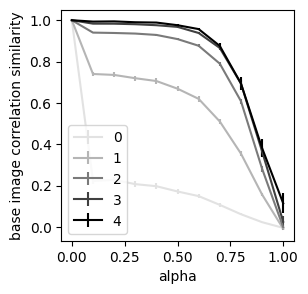

In [46]:
# multiscale analysis (Laplacian pyramid)
import pyrtools as pt

def psnr(im_1, im_2):
    max_1 = np.max(im_1)
    max_2 = np.max(im_2)
    max_total = max(max_1, max_2)
    im_1_norm = im_1 / max_total
    im_2_norm = im_2 / max_total
    mse = np.mean((im_1_norm - im_2_norm)**2)
    # psnr = 10 * np.log10(max_total) - 10 * np.log10(mse)
    return mse

alpha_range = np.arange(0, 1.1, 0.1)
sample_idx = 5
base_ims = samples[alpha_range[0]][0][sample_idx,...]
base_coeffs = pt.pyramids.LaplacianPyramid(base_ims[...].mean(axis = 2))
halluc_coeffs = []
for ii in range(0, len(samples)):
    halluc_coeffs.append(pt.pyramids.LaplacianPyramid(samples[alpha_range[ii]][0][sample_idx,...].mean(axis = 2)))
    # pt.pyrshow(halluc_coeffs[ii].pyr_coeffs)

plt.figure()
plt.imshow(samples[alpha_range[0]][0][sample_idx,...].mean(axis = 2), cmap = 'gray')

alpha_num = len(samples)
scale_num = len(base_coeffs.pyr_coeffs.keys())
sample_num = 100

fig, ax = plt.subplots(alpha_num, scale_num + 1, figsize = (3 * (scale_num + 1), 3 * alpha_num))
for ii in range(0, alpha_num):
    ax[ii,0].imshow(samples[alpha_range[ii]][0][sample_idx,...].mean(axis = 2), cmap = 'gray')
    ax[ii,0].set_xticks([])
    ax[ii,0].set_yticks([])
    for jj in range(1, scale_num + 1):
        ax[ii,jj].imshow(halluc_coeffs[ii].pyr_coeffs[(jj - 1, 0)], cmap = 'gray')
        ax[ii,jj].set_xticks([])
        ax[ii,jj].set_yticks([])


dists = torch.zeros(sample_num, alpha_num, scale_num)
for zz in range(0, sample_num):
    base_ims = samples[alpha_range[0]][0][zz,...]
    base_coeffs = pt.pyramids.LaplacianPyramid(base_ims[...].mean(axis = 2))
    halluc_coeffs = []
    for ii in range(0, len(samples)):
        halluc_coeffs.append(pt.pyramids.LaplacianPyramid(samples[alpha_range[ii]][0][zz,...].mean(axis = 2)))
    
    for ii in range(0, alpha_num):
        for jj in range(0, scale_num):
            lp_coeff_base = base_coeffs.pyr_coeffs[(jj, 0)]
            lp_coeff_alpha = halluc_coeffs[ii].pyr_coeffs[(jj, 0)]
            dists[zz,ii,jj] = corr_similarity(torch.tensor(lp_coeff_base), torch.tensor(lp_coeff_alpha))#psnr(lp_coeff_base, lp_coeff_alpha) #np.mean((lp_coeff_base - lp_coeff_alpha)**2)

plt.figure(figsize = (3,3))

scale_list = [0,1,2,3,4]
cmap = plt.cm.Greys(np.linspace(0.2,1,  len(scale_list)))
dists = dists #/ torch.max(dists, 0, keepdim = True)[0]
for ii in range(0, len(scale_list)):
    dist_mean = torch.mean(dists[:,:,ii], axis = 0)
    dist_sem = torch.std(dists[:,:,ii], axis = 0) / torch.sqrt(torch.tensor([sample_num]))
    plt.errorbar(alpha_range, dist_mean, yerr = dist_sem, color = cmap[ii])
plt.legend(scale_list)
plt.xlabel('alpha')
plt.ylabel('base image correlation similarity')

In [ ]:
# FID score